# Data Exploration

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
predictors = pd.read_csv('../../data/water_table_training.csv')
target = pd.read_csv('../../data/water_table_labels.csv')

df = predictors.merge(target, on = 'id')

count    51329.000000
mean      1334.765552
std        940.138379
min          0.000000
25%          0.000000
50%       1987.000000
75%       2005.000000
max       2013.000000
Name: construction_year, dtype: float64 
Mode: 0    2008.0
dtype: float64


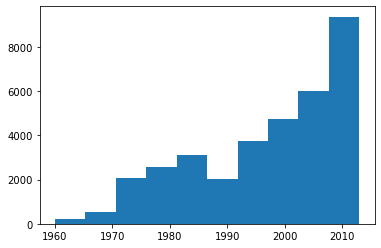

In [14]:
##selecting which columns to drop based off impact on prediction and overlapping information
columns = ['id', 'date_recorded', 'installer', 'wpt_name', 'num_private', 'region', 'subvillage', 
           'ward', 'recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'water_quality', 
           'quantity', 'source_type', 'waterpoint_type_group', 'public_meeting']


cleaned_df = df.drop(columns = columns, axis = 1)
cleaned_df.dropna(inplace = True)


##checking to see distribution of non-zero(np.nan) values to determine how to impute
## will impute with mode

print(cleaned_df.construction_year.describe(), '\nMode:', cleaned_df.construction_year.replace(0.0, np.nan).mode())
plt.hist(cleaned_df.construction_year.replace(0.0, np.nan));

In [15]:
#replacing string values for status group with 0, 1, or 1 in 'status_no'
#0 target is functional, 1 target is non or needs repair (positive class for predicting)

conditions = [cleaned_df['status_group'] == 'functional', cleaned_df['status_group'] == 'functional needs repair', cleaned_df['status_group'] == 'non functional']
choices = [0, 1, 1]

cleaned_df['status_no'] = np.select(conditions, choices)
cleaned_df.drop('status_group', axis = 1, inplace = True)

##Separating predictor feature columns into categorical and continuous value groups
#continuous features
numerical_columns = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']
#categorical features without the target of 'status_group'
categorical_columns = cleaned_df.select_dtypes(include = 'object').columns


##Smaller amount of features to reduce computational strain - using all categoricals turned into 1600+ columns
final_columns_list = ['amount_tsh', 'longitude', 'latitude', 'construction_year', 'region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']

numericals = ['amount_tsh', 'longitude', 'latitude', 'construction_year']
categoricals = ['region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']


## A Bit of EDA

Functional: 0  
Non-functional or functional needs repair: 1  
It looks to be that there is a high count of non-functional or needs-repairs sources built between 1982 and 2004.

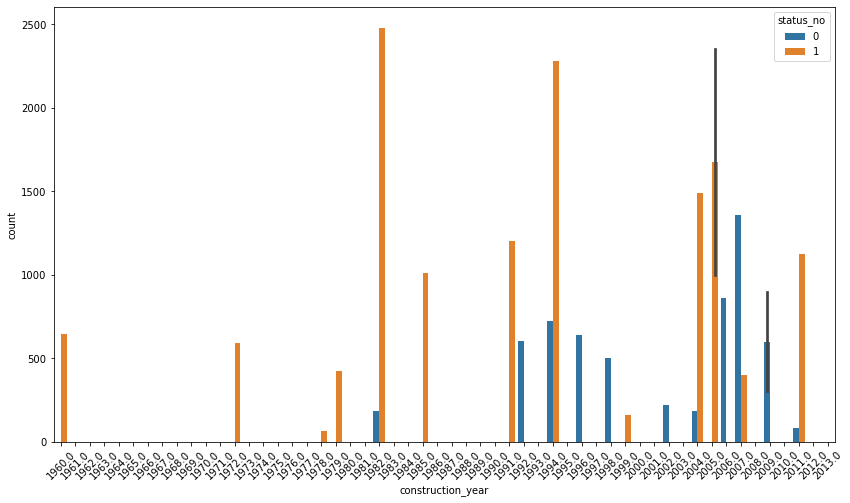

In [16]:
plotting_df = cleaned_df.copy()
plotting_df['construction_year'] = plotting_df.construction_year.replace(0.0, np.nan)
plotting_df['count'] = plotting_df.construction_year.value_counts()

fig, ax = plt.subplots(figsize=(14,8))
ax = sns.barplot(x="construction_year", y="count", hue="status_no", data=plotting_df, ax = ax)
plt.xticks(rotation=45);

## Modeling

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier


X = cleaned_df[final_columns_list]
y = cleaned_df['status_no']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 42)

### Transformation on the Train Set

In [18]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        self.column_trans = None
#        self.ohe_col_names = None
    
    def fit(self, X_t, y_t = None):
        X_ = X_t.copy()
        column_transformer = ColumnTransformer(transformers = [('imputer', SimpleImputer(missing_values = 0.0, strategy = 'most_frequent'), ['construction_year']),                     
                                                      ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'), categoricals)],
 
                                                      n_jobs = -1)
        column_transformer = column_transformer.fit(X_)
#        self.ohe_col_names = column_transformer.named_transformers_['ohe'].categories_[0]
        self.column_trans = column_transformer
        return column_transformer
    
    def transform(self, X, y = None):

        X_ = self.column_trans.transform(X)
        return X_
        

## Pipelines

In [21]:
logreg_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('logreg', LogisticRegression())])
bernoulli_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('bern', BernoulliNB())])
knn_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('knn', KNeighborsClassifier())])
tree_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('tree', DecisionTreeClassifier())])
forest_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('forest', RandomForestClassifier())])
xgb_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('xgb', XGBClassifier())])


### GridSearchCV parameters

In [22]:
logreg_params = {
   'logreg__C':[.1, .75],
   'logreg__max_iter':[500],
   'logreg__solver':['lbfgs', 'liblinear']
            }
                       
bernoulli_params = {'bern__alpha': list(np.linspace(.1, 1, 10))}

knn_params = {
    'knn__n_neighbors': [3, 7, 12], 
    'knn__weights':['uniform', 'distance'], 
    'knn__p':[1, 2, 3, 4]
             }

tree_params = {
    'tree__criterion':['gini', 'entropy'],  
    'tree__max_depth': [10, 25, 40, 55],
    'tree__min_samples_leaf':[1, 2, 3], 
    'tree__max_features': ['auto', 'sqrt']
              } 
forest_params = {
    'forest__n_estimators':[100, 125],
    'forest__criterion':['gini', 'entropy'],
    'forest__max_depth':[20, 40, None],
    'forest__min_samples_leaf':[1, 2, 3], 
    'forest__max_features': ['auto','sqrt', 'log2']
                }

xgb_params = {
        'xgb__eta':[.7, .9, 1.1],
        'xgb__max_depth': [6, 10, 15, 20],
        'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'xgb__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'xgb__gamma': [0, 0.25, 0.5, 1.0],
        'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'xgb__n_estimators': [100, 120]
            }

### Logistic Regression

In [23]:
log_grid = GridSearchCV(estimator = logreg_pipe, param_grid = logreg_params, scoring = 'recall')

In [24]:
log_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 0.75], 'logreg__max_iter': [500],
                         'logreg__solver': ['lbfgs', 'liblinear']},
             scoring='recall')

In [25]:
log_grid.best_params_

{'logreg__C': 0.75, 'logreg__max_iter': 500, 'logreg__solver': 'lbfgs'}

### Bernoulli

In [26]:
bern_grid = GridSearchCV(estimator = bernoulli_pipe, param_grid = bernoulli_params, scoring = 'recall')

In [13]:
bern_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('bern', BernoulliNB())]),
             param_grid={'bern__alpha': [0.1, 0.2, 0.30000000000000004, 0.4,
                                         0.5, 0.6, 0.7000000000000001, 0.8, 0.9,
                                         1.0]},
             scoring='recall')

In [14]:
bern_grid.best_params_

{'bern__alpha': 0.1}

### RandomSearchCV on K Nearest Neighbors

Tossing this one due to computational weight.

In [15]:
#rs_knn = RandomizedSearchCV(estimator = knn_pipe,
#                        param_distributions = knn_params,
#                        n_iter = 10,                      
#                        random_state=42)

#rs_knn.fit(X_train, y_train)

In [16]:
#rs_knn.fit(X_train, y_train)

In [17]:
#rs_knn.best_params_

### Decision Tree

In [18]:
tree_grid = GridSearchCV(estimator = tree_pipe, param_grid = tree_params, scoring = 'recall')

In [19]:
tree_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid={'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [10, 25, 40, 55],
                         'tree__max_features': ['auto', 'sqrt'],
                         'tree__min_samples_leaf': [1, 2, 3]},
             scoring='recall')

In [20]:
tree_grid.best_params_

{'tree__criterion': 'entropy',
 'tree__max_depth': 40,
 'tree__max_features': 'sqrt',
 'tree__min_samples_leaf': 1}

### RandomSearchCV on Random Forest

In [21]:
rs_forest = RandomizedSearchCV(estimator = forest_pipe,
                        param_distributions = forest_params,
                        n_iter = 10,                      
                        random_state=42)

rs_forest.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                             ('scaler', StandardScaler()),
                                             ('forest',
                                              RandomForestClassifier())]),
                   param_distributions={'forest__criterion': ['gini',
                                                              'entropy'],
                                        'forest__max_depth': [20, 40, None],
                                        'forest__max_features': ['auto', 'sqrt',
                                                                 'log2'],
                                        'forest__min_samples_leaf': [1, 2, 3],
                                        'forest__n_estimators': [100, 125]},
                   random_state=42)

In [22]:
rs_forest.best_params_

{'forest__n_estimators': 125,
 'forest__min_samples_leaf': 2,
 'forest__max_features': 'sqrt',
 'forest__max_depth': None,
 'forest__criterion': 'gini'}

## XGBoost

### RandomSearchCV on XGB

Gridsearch is very computationally heavy so RandomSearch had to be used to reduce computation - still very heavy.

In [23]:
rs = RandomizedSearchCV(estimator = xgb_pipe,
                        param_distributions = xgb_params,
                        n_iter = 10,                      
                        random_state=42, return_train_score = True)

rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                             ('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            learning_ra

In [24]:
rs.best_params_, rs.best_score_

({'xgb__subsample': 0.9,
  'xgb__reg_lambda': 1.0,
  'xgb__n_estimators': 120,
  'xgb__min_child_weight': 1.0,
  'xgb__max_depth': 15,
  'xgb__learning_rate': 0.1,
  'xgb__gamma': 1.0,
  'xgb__eta': 0.9,
  'xgb__colsample_bytree': 0.9,
  'xgb__colsample_bylevel': 0.5},
 0.7911744499486368)

In [96]:
rs.__dict__

{'param_distributions': {'xgb__eta': [0.7, 0.9, 1.1],
  'xgb__max_depth': [6, 10, 15, 20],
  'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
  'xgb__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
  'xgb__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
  'xgb__colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
  'xgb__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
  'xgb__gamma': [0, 0.25, 0.5, 1.0],
  'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
  'xgb__n_estimators': [100, 120]},
 'n_iter': 10,
 'random_state': 42,
 'scoring': None,
 'estimator': Pipeline(steps=[('transform', CustomTransformer()),
                 ('scaler', StandardScaler()),
                 ('xgb',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                        

# First Simple Model on Binary Data

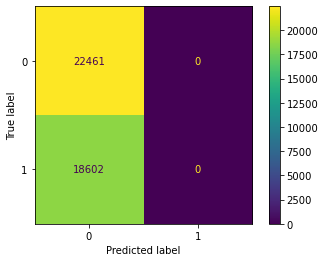

In [12]:
dummy_model = DummyClassifier(strategy = 'most_frequent')
dummy_model.fit(X_train, y_train)

plot_confusion_matrix(dummy_model, X_train, y_train);

In [13]:
print("Accuracy Scores:", cross_val_score(dummy_model, X_train, y_train))
print("Mean Accuracy:", cross_val_score(dummy_model, X_train, y_train).mean())
"Recall Scores:", cross_validate(dummy_model, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.54705954 0.54693778 0.54693778 0.54700438 0.54700438]
Mean Accuracy: 0.5469887741085512


('Recall Scores:',
 {'fit_time': array([0.00502992, 0.00498676, 0.00398993, 0.00498199, 0.00496435]),
  'score_time': array([0.00297618, 0.00199437, 0.00399184, 0.00399065, 0.00396943]),
  'test_score': array([0., 0., 0., 0., 0.]),
  'train_score': array([0., 0., 0., 0., 0.])})

# Vanilla Models

## Model 1 - Logistic Regression

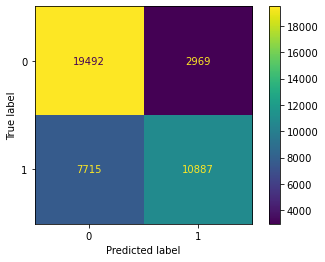

In [26]:
logreg_pipe.fit(X_train, y_train)
plot_confusion_matrix(logreg_pipe, X_train, y_train);

In [27]:
print("Accuracy Scores:", cross_val_score(logreg_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(logreg_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(logreg_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.73882869 0.74211616 0.73773286 0.73514369 0.74171943]
Mean Accuracy: 0.7391081666413524


('Recall Scores:',
 {'fit_time': array([0.47884846, 0.47772336, 0.48189902, 0.46174884, 0.51243305]),
  'score_time': array([0.06304908, 0.05684781, 0.05451632, 0.04483986, 0.05983782]),
  'test_score': array([0.58198925, 0.58989519, 0.58452029, 0.57043011, 0.58844086]),
  'train_score': array([0.58607714, 0.58147974, 0.58571333, 0.58721946, 0.58533799])})

## Model 2 - K Nearest Neighbors

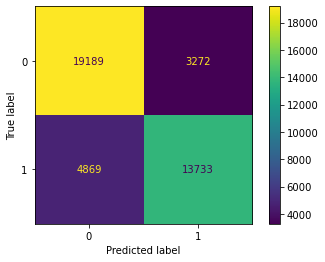

In [28]:
knn_pipe.fit(X_train, y_train)
plot_confusion_matrix(knn_pipe, X_train, y_train);

In [29]:
#print("Accuracy Scores:", cross_val_score(knn_pipe, X_train, y_train))
#"Recall Scores:", cross_validate(knn_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')
#do not uncomment unless you're comfortable with waiting a really long time

## Model 3 - Decision Tree Classifier

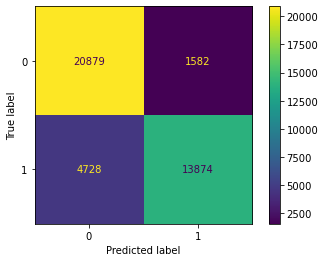

In [30]:
tree_pipe.fit(X_train, y_train)
plot_confusion_matrix(tree_pipe, X_train, y_train);

In [31]:
print("Accuracy Scores:", cross_val_score(tree_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(tree_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(tree_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.77645197 0.78753196 0.7784001  0.7788602  0.77411106]
Mean Accuracy: 0.7785109459899537


('Recall Scores:',
 {'fit_time': array([0.7108736 , 0.6476295 , 0.67972517, 0.6491046 , 0.61254382]),
  'score_time': array([0.05784392, 0.04570961, 0.04825616, 0.04265618, 0.0458765 ]),
  'test_score': array([0.65672043, 0.68073099, 0.66595001, 0.66639785, 0.66774194]),
  'train_score': array([0.74620347, 0.74779921, 0.74490962, 0.74801774, 0.74895847])})

## Model 4 - XGB Classifier

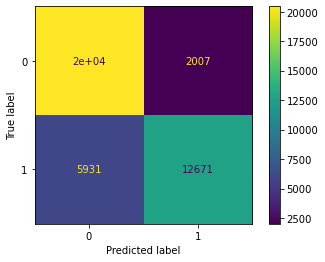

In [32]:
xgb_pipe.fit(X_train, y_train)
plot_confusion_matrix(xgb_pipe, X_train, y_train);

In [33]:
print("Accuracy Scores:", cross_val_score(xgb_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(xgb_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(xgb_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.78144405 0.79763789 0.7850968  0.78190453 0.78531417]
Mean Accuracy: 0.7862794890710905


('Recall Scores:',
 {'fit_time': array([3.62005496, 3.55619574, 3.58899975, 3.60343003, 3.5615921 ]),
  'score_time': array([0.16591358, 0.15313077, 0.14293194, 0.14278817, 0.14486957]),
  'test_score': array([0.65456989, 0.6855684 , 0.6640688 , 0.65806452, 0.65349462]),
  'train_score': array([0.68841554, 0.68973859, 0.6886634 , 0.69231286, 0.68062088])})

## Model 5 - Random Forest Classifier

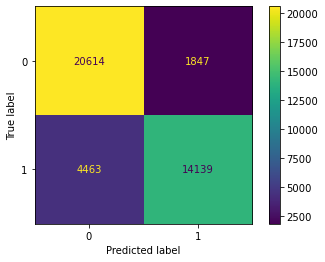

In [34]:
forest_pipe.fit(X_train, y_train)
plot_confusion_matrix(forest_pipe, X_train, y_train);

In [36]:
print("Accuracy Scores:", cross_val_score(forest_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(forest_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(forest_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.78375746 0.79069767 0.78400097 0.78324403 0.78226985]
Mean Accuracy: 0.7851105867410256


('Recall Scores:',
 {'fit_time': array([4.33274388, 3.94697905, 4.15101624, 4.02547622, 4.20825028]),
  'score_time': array([0.24612117, 0.23344517, 0.2353723 , 0.24171138, 0.25878572]),
  'test_score': array([0.68064516, 0.70384305, 0.6904058 , 0.68978495, 0.69569892]),
  'train_score': array([0.76293509, 0.76271756, 0.76217996, 0.7656901 , 0.76958742])})

# Tuned Models

## Tuned Model 1 - Decision Tree

In [37]:
tree_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()), 
                                   ('tree', DecisionTreeClassifier(criterion = 'entropy',
                                                                   max_depth = 30,
                                                                   max_features = 'sqrt'))])

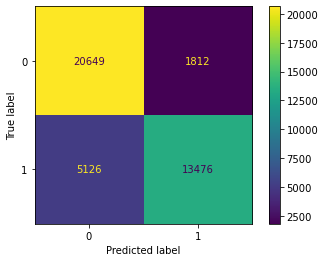

In [39]:
tree_pipe_tuned.fit(X_train, y_train)
plot_confusion_matrix(tree_pipe_tuned, X_train, y_train);

In [40]:
print("Accuracy Scores:", cross_val_score(tree_pipe_tuned, X_train, y_train))
print("Mean Accuracy:", cross_val_score(tree_pipe_tuned, X_train, y_train).mean())
"Recall Scores:", cross_validate(tree_pipe_tuned, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.77267746 0.78144405 0.77572142 0.77386751 0.77398928]
Mean Accuracy: 0.7760512052192452


('Recall Scores:',
 {'fit_time': array([0.33709812, 0.32420588, 0.35734487, 0.34008861, 0.34670258]),
  'score_time': array([0.05285811, 0.03982449, 0.03933477, 0.03774953, 0.04581022]),
  'test_score': array([0.65349462, 0.67320613, 0.65063155, 0.62768817, 0.63897849]),
  'train_score': array([0.73101734, 0.72737047, 0.72091929, 0.70541594, 0.70118264])})

## Tuned Model 2 - XGBoost Classifier

Trial and error tuning of parameters beginning at Search results led to the following being the most successful:

In [129]:
xgb_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()), 
                                  ('xgb', XGBClassifier(subsample=0.9,
                                                        reg_lambda=.1,
                                                        n_estimators=500,
                                                        booster = 'dart',
                                                        min_child_weight=1.0,
                                                        max_depth=40,
                                                        learning_rate=0.3,
                                                        gamma=.8,
                                                        eta=0.9,
                                                        colsample_bytree=0.9,
                                                        colsample_bylevel=0.5))])

#estimators = 500, depth = 40, lr = .3, lambda = .1, gamma = .8 20612 1849 4469 14133
#estimators = 500 depth = 40 lr = .3 lambda = 

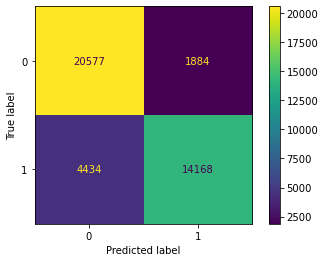

In [130]:
xgb_pipe_tuned.fit(X_train, y_train)
plot_confusion_matrix(xgb_pipe_tuned, X_train, y_train);

The recall calculations below take a little while, but they do work.  

In [52]:
print("Accuracy Scores:", cross_val_score(xgb_pipe_tuned, X_train, y_train))
print("Mean Accuracy:", cross_val_score(xgb_pipe_tuned, X_train, y_train).mean())
"Recall Scores:", cross_validate(xgb_pipe_tuned, X_train, y_train, return_train_score= True, scoring = 'recall')

KeyboardInterrupt: 

Example result:

Accuracy Scores: [0.78667965 0.79374163 0.78570559 0.78592304 0.78677545]  
Mean Accuracy: 0.7877650724093515  
('Recall Scores:',  
 {'fit_time': array([21.27556515, 20.48738503, 20.44357967, 19.84486055, 19.39542603]),  
  'score_time': array([0.21004176, 0.20481229, 0.1889286 , 0.17752552, 0.20445323]),  
  'test_score': array([0.67903226, 0.70357431, 0.68691212, 0.68494624, 0.6983871 ]),  
  'train_score': array([0.74828652, 0.749412  , 0.74826961, 0.7485553 , 0.75251982])})  

## Tuned Model 3 - Random Forest Classifier

In [112]:
forest_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),
                                     ('forest', RandomForestClassifier(n_estimators=7000,
                                                                       max_features='sqrt',
                                                                       max_depth=40,
                                                                       criterion='gini', 
                                                                       max_samples = 35000))])


#estimators = 1000, features = sqrt, depth = 35, criterion = entropy 20692 1769 4547 14055
#estimators = 1000, features = auto, depth = 35, criterion = entropy 20700 1761 4554 14048
#estimators = 1000, features = log2, depth = 35, criterion = entropy 20712 1749 4567 14035
#estimators = 1000, features = sqrt, depth = 35, criterion = gini    20689 1772 4542 14060

##increasing max samples is significantly imporving recall - best performance with all samples?
#estimators = 1000, features = sqrt, depth = 35, criterion = gini samples = 9000 20000 2072 4959 13643
#estimators = 1000, features = sqrt, depth = 35, criterion = gini samples = 22000 20625 1836 4636 13966
#estimators = 1000, features = sqrt, depth = 35, criterion = gini samples = 35000 20691 1770 4545 14057


#maxing out success at approximately 10k estimators and 40k samples - this is very time consuming.

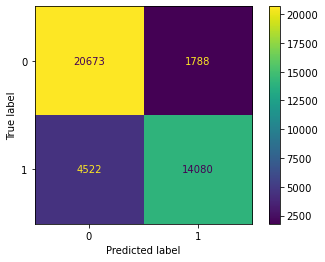

In [113]:
forest_pipe_tuned.fit(X_train, y_train)
plot_confusion_matrix(forest_pipe_tuned, X_train, y_train);

In [14]:
print("Accuracy Scores:", cross_val_score(forest_pipe_tuned, X_train, y_train))
print("Mean Accuracy:", cross_val_score(forest_pipe_tuned, X_train, y_train).mean())
"Recall Scores:", cross_validate(forest_pipe_tuned, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.73334957 0.73615001 0.73590649 0.72540185 0.72552362]
Mean Accuracy: 0.7327518139330866


('Recall Scores:',
 {'fit_time': array([19.71906281, 19.29850221, 19.39448309, 19.43904495, 19.81945372]),
  'score_time': array([0.88479424, 0.92607927, 0.89118695, 0.87181592, 0.88475323]),
  'test_score': array([0.47715054, 0.48696587, 0.48105348, 0.45752688, 0.47150538]),
  'train_score': array([0.47412982, 0.47140649, 0.47577448, 0.47742239, 0.47916947])})

In [16]:
forest_y_preds = forest_pipe_tuned.predict(X_train)

In [44]:
sorted(forest_pipe_tuned.steps[2][1].feature_importances_, reverse = True)[:10]

[0.28142320260048476,
 0.1331170125004302,
 0.11084267398595803,
 0.09468476945012892,
 0.06387736724091335,
 0.04167038358433022,
 0.0387977148066944,
 0.032598101773420235,
 0.024587540212714944,
 0.01728511892213828]

# Test Set

### XGBoost Classifier predictions on the test set

In [90]:
xgb_pipe_tuned.fit(X_train, y_train)

xgb_train_preds = xgb_pipe_tuned.predict(X_train)
xgb_test_preds = xgb_pipe_tuned.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_test_preds)
xgb_precision = precision_score(y_test, xgb_test_preds)
xgb_recall = recall_score(y_test, xgb_test_preds)

xgb_y_probas = xgb_pipe_tuned.predict_proba(X_test)[:,1]
xgb_tpr, xgb_fpr, xgb_thresholds = roc_curve(y_test, xgb_y_probas)
xgb_auc = auc(xgb_tpr, xgb_fpr)


print("XGBoost Classifier Stats:")
print("Test Accuracy: ", xgb_accuracy)
print("Test Precision: ", xgb_precision)
print("Test Recall: ", xgb_recall)

XGBoost Classifier Stats:
Test Accuracy:  0.7919345412039743
Test Precision:  0.8187579214195184
Test Recall:  0.6944743066007311


### Random Forest Classifier predictions on the test set

In [91]:
forest_pipe_tuned.fit(X_train, y_train)

forest_train_preds = forest_pipe_tuned.predict(X_train)
forest_test_preds = forest_pipe_tuned.predict(X_test)

forest_accuracy = accuracy_score(y_test, forest_test_preds)
forest_precision = precision_score(y_test, forest_test_preds)
forest_recall = recall_score(y_test, forest_test_preds)

forest_y_probas = forest_pipe_tuned.predict_proba(X_test)[:,1]
forest_tpr, forest_fpr, forest_thresholds = roc_curve(y_test, forest_y_probas)
forest_auc = auc(forest_tpr, forest_fpr)

print("Random Forest Classifier Stats:")
print("Test Accuracy: ", forest_accuracy)
print("Test Precision: ", forest_precision)
print("Test Recall: ", forest_recall)

Random Forest Classifier Stats:
Test Accuracy:  0.7920319501266316
Test Precision:  0.8173562058526741
Test Recall:  0.6966243818533648


Additional Data Explanation

feature importances - their direction, correlation to classes, 
find test errors  - look for patterns in incorrect predictions, outliers, 
look at individual trees in the forest  
test set data - distributions, features, fp/fn  
look at cost of errors - explore costs of fp vs fn  
correlation of errors between unused features and used features  

## Tuned Model ROC Curves against each other on Train set

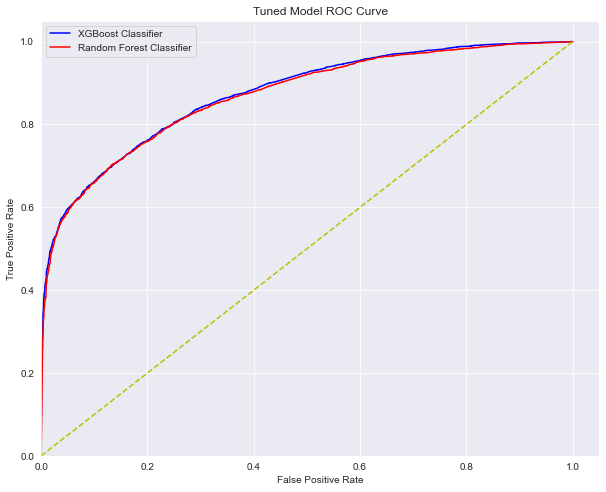

In [95]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))

plt.plot(xgb_tpr, xgb_fpr, color = 'b', label = 'XGBoost Classifier')
plt.plot(forest_tpr, forest_fpr, color = 'r', label = 'Random Forest Classifier')
plt.plot([0, 1], [0, 1], color = 'y', linestyle = '--')

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Model ROC Curve')
plt.legend()
plt.show()